In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
api = KaggleApi()
api.authenticate()

In [17]:
api.competition_download_file("spaceship-titanic",file_name="test.csv")

100%|██████████| 364k/364k [00:00<00:00, 4.34MB/s]

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
X = pd.read_csv("train.csv")
Xdata = X.copy()

In [39]:
Xt = pd.read_csv("test.csv")
Xtdata = Xt.copy()

In [4]:
Xdata.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [7]:
find_missing(Xdata)

[['Age', 179, dtype('float64')],
 ['RoomService', 181, dtype('float64')],
 ['Destination', 182, dtype('O')],
 ['FoodCourt', 183, dtype('float64')],
 ['Spa', 183, dtype('float64')],
 ['VRDeck', 188, dtype('float64')],
 ['Cabin', 199, dtype('O')],
 ['Name', 200, dtype('O')],
 ['HomePlanet', 201, dtype('O')],
 ['VIP', 203, dtype('O')],
 ['ShoppingMall', 208, dtype('float64')],
 ['CryoSleep', 217, dtype('O')]]

12

In [8]:
find_missing(Xtdata)

[['VRDeck', 80, dtype('float64')],
 ['RoomService', 82, dtype('float64')],
 ['HomePlanet', 87, dtype('O')],
 ['Age', 91, dtype('float64')],
 ['Destination', 92, dtype('O')],
 ['CryoSleep', 93, dtype('O')],
 ['VIP', 93, dtype('O')],
 ['Name', 94, dtype('O')],
 ['ShoppingMall', 98, dtype('float64')],
 ['Cabin', 100, dtype('O')],
 ['Spa', 101, dtype('float64')],
 ['FoodCourt', 106, dtype('float64')]]

12

In [9]:
# part of a feature engineering
Xdata[["Group_number","Group_id"]] = Xdata.PassengerId.str.split("_",expand=True)
Xdata[["Deck","Num","Side"]] = Xdata.Cabin.str.split("/",expand=True)
Xdata.drop(labels=["PassengerId","Cabin","Name"],axis=1,inplace=True)

In [191]:
Xdata.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_number,Group_id,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,0001,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,0002,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,0004,01,F,1,S


In [10]:
cat_feature = ["HomePlanet","CryoSleep","Destination","VIP","Deck","Side"]
int_feature = ["Group_number","Group_id"]

In [11]:
Xdata = encode(Xdata,cat_feature,int_feature)

In [6]:
def encode(X,cat_f,int_f):
    """
    X: dataframe
    cat_f: list of features to categorise
    int_f: list of features to convert into integer
    returns encoded dataset
    """
    for name in cat_f:
        X[name] = X[name].astype("category")   
        if "None" not in X[name].cat.categories:
            X[name].cat.add_categories("None", inplace=True)
    for name in int_f:
        X[name] = X[name].astype("int32")
    return X
def find_missing(Xdata):
    """
    Xdata: dataframe
    return sorted missing values columns of given dataset.
    """ 
    from IPython.display import display
    missing_values_columns = [[col,Xdata[col].isnull().sum(),Xdata[col].dtypes] for col in Xdata.columns if Xdata[col].isnull().any()]
    display(sorted(missing_values_columns, key=(lambda k:k[1])),len(missing_values_columns))
def impute(X):
    """
    X: dataframe
    return imputed dataframe
    """
    X.HomePlanet = X.HomePlanet.fillna("Earth")
#     X.CryoSleep.fillna(lambda a: random.choice([True,False]), inplace=True)
    X.CryoSleep = X.CryoSleep.fillna(method="ffill")
    X.Destination = X.Destination.fillna(method="ffill")
    X.Age = X.Age.fillna(X.Age.median())
    X.VIP = X.VIP.fillna(False)
#     X.VIP.fillna(lambda a: random.choice([True,False]), inplace=True)
#     try below code also according to vip value
    for col in ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]:
        X[col] = X[col].fillna(0)
    X.Deck = X.Deck.fillna("None") 
    X.Deck = X.Deck.map(lambda x: x if(x!="None") else random.choice(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']))
    X.Deck = X.Deck.astype("category")
    X.Num = X.Num.fillna(-1)
    X.Num = X.Num.map(lambda x: x if(x!=-1) else random.randint(0,1894))
    X.Num = X.Num.astype("int32")
    X.Side = X.Side.fillna("None")
    X.Side = X.Side.map(lambda x: x if(x!="None") else random.choice(["S","P"]))
    X.Side = X.Side.astype("category")
    return X

In [12]:
data_corr = Xdata[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].corr()
data_corr

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
RoomService,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,-0.019581,0.227995,-0.007322,0.153821,1.000000


<AxesSubplot:>

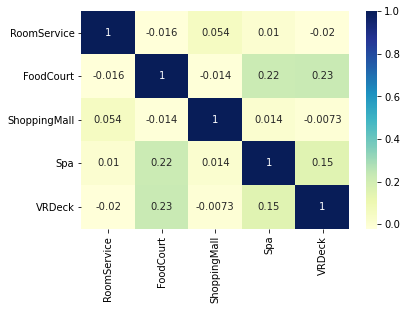

In [13]:
sns.heatmap(data_corr, cmap="YlGnBu", annot=True)

# deal with null values

assume train and test data are similar types in null values.
1. PassengerId (so as Group_number and Group_id) and Name both are not required to impute.
2. Remove PassengerId and name feature.
3. Impute HomePlanet with most_frequent which is Earth (also check for ffill or bfill)
4. impute CryoSleep with random value between 0 or 1 (also with most frequent which is 0 or by ffill).
5. Destination can be imputed by ffill method (also try with random choice)
6. Age is imputed by mean/median method.
7. VIP can be predicted by using RoomService,FoodCourt,ShoppingMall,Spa,VRDeck imputation is used by this method when VIP is important for Final target. or VIP can be imputed by random choice or most frequent which is false or zero.
8. all 5 RoomService,FoodCourt,ShoppingMall,Spa and VRDeck are:
            exponentially distributed : impute median value or 
            large interaction with VIP: impute mean(0 for all 5 features) if if VIP=True and impute median if VIP=False or
            FoodCourt is more than 20% correlated with Spa and VRDeck
9. Deck is imputed by most frequent method, Num by mean/median and Side by random choice


In [16]:
Xdata = impute(Xdata)

In [17]:
Xdata.dtypes

HomePlanet      category
CryoSleep       category
Destination     category
Age              float64
VIP             category
RoomService      float64
FoodCourt        float64
ShoppingMall     float64
Spa              float64
VRDeck           float64
Transported         bool
Group_number       int32
Group_id           int32
Deck            category
Num                int32
Side            category
dtype: object

In [19]:
# add a feature named T_expense which is total expense of a person on spaceship
Xdata["T_expense"] = Xdata.RoomService + Xdata.FoodCourt + Xdata.ShoppingMall + Xdata.Spa + Xdata.VRDeck

In [20]:
Xdata.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group_number,Group_id,Deck,Num,Side,T_expense
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S,1091.0


<AxesSubplot:xlabel='Deck', ylabel='Count'>

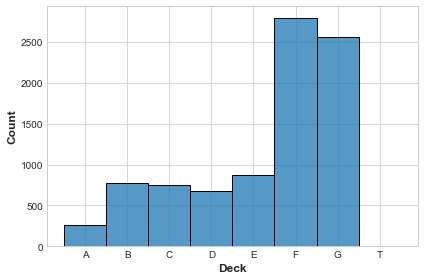

In [243]:
sns.histplot(Xdata.Deck)

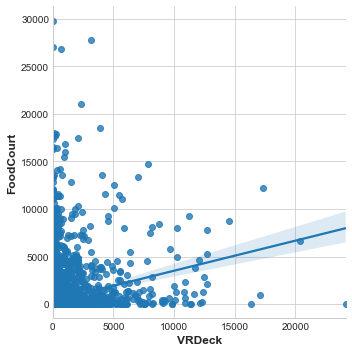

In [244]:
sns.lmplot(x="VRDeck",y="FoodCourt",data=Xdata)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

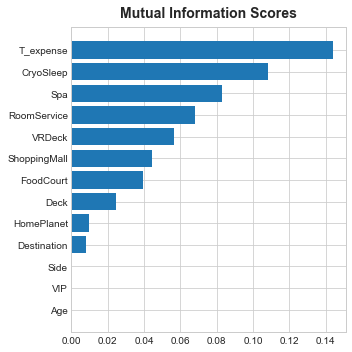

In [21]:
from sklearn.feature_selection import mutual_info_regression
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # it returns codes and uniques
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    discrete_features = X.dtypes == int # double check for discrete feature of integer type
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
plt.figure(figsize=(5,5))
mi_scores = make_mi_scores(Xdata.drop(labels=['Transported',"Group_number","Group_id","Num"],axis=1,),Xdata.Transported)
plot_mi_scores(mi_scores)

In [22]:
# Group_number, Group_id and Num are numarically not play a role in classification 
# categorically they contain very large value automatically removed if categorical encoding (into numbers)
# so it is better to remove these in train test split.
xtrain,xvalid,ytrain,yvalid = train_test_split(Xdata.drop(labels=["Group_number","Num","Transported"],axis=1),Xdata.Transported, train_size=0.8, test_size=0.2, random_state=0)

In [304]:
xtrain.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,Deck,Side,T_expense
4278,Europa,False,55 Cancri e,54.0,False,0.0,559.0,0.0,15238.0,2799.0,1,C,S,18596.0
5971,Earth,False,TRAPPIST-1e,20.0,False,0.0,20.0,1.0,696.0,0.0,1,F,P,717.0
464,Mars,False,TRAPPIST-1e,43.0,False,1821.0,0.0,47.0,29.0,0.0,2,F,S,1897.0
4475,Earth,False,TRAPPIST-1e,24.0,False,185.0,0.0,476.0,1810.0,53.0,1,F,S,2524.0
8469,Europa,True,55 Cancri e,25.0,False,0.0,0.0,0.0,0.0,0.0,1,C,S,0.0


In [25]:
mapping_feature = [ 
                    {'col':'CryoSleep', 'mapping':{False:0,True:1}},
                    {'col':'VIP', 'mapping':{False:0,True:1}}
                  ]
ordinal_encoder = OrdinalEncoder(cols=["CryoSleep","VIP"],mapping=mapping_feature )#,mapping=mapping
label_X_train = ordinal_encoder.fit_transform(xtrain)
label_X_valid = ordinal_encoder.transform(xvalid)

In [26]:
onehot_encoder = OneHotEncoder(cols=["HomePlanet","Destination","Deck","Side","Group_id"])
final_X_train = onehot_encoder.fit_transform(label_X_train)
final_X_valid = onehot_encoder.transform(label_X_valid)

In [27]:
ordinal_encoder2 = OrdinalEncoder(cols=["HomePlanet","Destination","Deck","Side"])
num_X_train = ordinal_encoder2.fit_transform(label_X_train)
num_X_valid = ordinal_encoder2.transform(label_X_valid)

In [28]:
num_X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,Deck,Side,T_expense
4278,1,0,1,54.0,0,0.0,559.0,0.0,15238.0,2799.0,1,1,1,18596.0
5971,2,0,2,20.0,0,0.0,20.0,1.0,696.0,0.0,1,2,2,717.0
464,3,0,2,43.0,0,1821.0,0.0,47.0,29.0,0.0,2,2,1,1897.0
4475,2,0,2,24.0,0,185.0,0.0,476.0,1810.0,53.0,1,2,1,2524.0
8469,1,1,1,25.0,0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0


In [29]:
final_X_train.head()

,HomePlanet_1,HomePlanet_2,HomePlanet_3,CryoSleep,Destination_1,Destination_2,Destination_3,Age,VIP,RoomService,...,Deck_2,Deck_3,Deck_4,Deck_5,Deck_6,Deck_7,Deck_8,Side_1,Side_2,T_expense
4278,1,0,0,0,1,0,0,54.0,0,0.0,...,0,0,0,0,0,0,0,1,0,18596.0
5971,0,1,0,0,0,1,0,20.0,0,0.0,...,1,0,0,0,0,0,0,0,1,717.0
464,0,0,1,0,0,1,0,43.0,0,1821.0,...,1,0,0,0,0,0,0,1,0,1897.0
4475,0,1,0,0,0,1,0,24.0,0,185.0,...,1,0,0,0,0,0,0,1,0,2524.0
8469,1,0,0,1,1,0,0,25.0,0,0.0,...,0,0,0,0,0,0,0,1,0,0.0


In [30]:
num_X_train.corr()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_id,Deck,Side,T_expense
HomePlanet,1.000000,-0.047413,0.213523,-0.121311,-0.062814,0.189599,-0.311117,0.076685,-0.222466,-0.246067,-0.072125,-0.110746,0.044793,-0.300962
CryoSleep,-0.047413,1.000000,-0.004714,-0.070148,-0.075728,-0.240750,-0.205997,-0.203682,-0.197229,-0.192584,0.053293,0.164285,-0.025003,-0.379619
Destination,0.213523,-0.004714,1.000000,-0.018206,-0.034273,-0.018611,-0.131997,-0.003830,-0.075500,-0.086700,-0.059895,0.050484,0.014417,-0.145660
Age,-0.121311,-0.070148,-0.018206,1.000000,0.092948,0.064585,0.127748,0.031091,0.114059,0.100377,-0.145653,-0.071692,-0.017056,0.181786
VIP,-0.062814,-0.075728,-0.034273,0.092948,1.000000,0.055938,0.115719,0.023596,0.069037,0.132765,0.007387,0.032727,0.015077,0.166302
RoomService,0.189599,-0.240750,-0.018611,0.064585,0.055938,1.000000,-0.010378,0.043190,0.015674,-0.015917,-0.015620,-0.054263,0.010802,0.250497
FoodCourt,-0.311117,-0.205997,-0.131997,0.127748,0.115719,-0.010378,1.000000,-0.014406,0.205244,0.215896,0.024089,-0.044439,-0.028043,0.730306
ShoppingMall,0.076685,-0.203682,-0.003830,0.031091,0.023596,0.043190,-0.014406,1.000000,0.019299,-0.012883,-0.039906,-0.067679,0.020010,0.232677
Spa,-0.222466,-0.197229,-0.075500,0.114059,0.069037,0.015674,0.205244,0.019299,1.000000,0.152706,0.021013,-0.032674,-0.007562,0.586464
VRDeck,-0.246067,-0.192584,-0.086700,0.100377,0.132765,-0.015917,0.215896,-0.012883,0.152706,1.000000,0.002292,-0.054592,-0.001065,0.583130


In [77]:
xgb_c1 = XGBClassifier(n_estimators=320,learning_rate=0.1)
xgb_c1.fit(X=num_X_train,y=ytrain)
score = xgb_c1.score(X=num_X_valid,y=yvalid)
print(score)

0.7993099482461185


In [61]:
xgb_c

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [78]:
xgb_c2 = XGBClassifier(n_estimators=310,learning_rate=0.1)
xgb_c2.fit(X=final_X_train,y=ytrain)
score = xgb_c2.score(X=final_X_valid,y=yvalid)
print(score)

0.7958596894767107


In [33]:
id_testdata = Xtdata.drop(Xtdata.columns.difference(["PassengerId"]), axis=1)

In [40]:
# part of a feature engineering
Xtdata[["Group_number","Group_id"]] = Xtdata.PassengerId.str.split("_",expand=True)
Xtdata[["Deck","Num","Side"]] = Xtdata.Cabin.str.split("/",expand=True)
Xtdata.drop(labels=["PassengerId","Cabin","Name"],axis=1,inplace=True)

In [41]:
Xtdata = encode(Xtdata,cat_feature,int_feature)
Xtdata = impute(Xtdata)
Xtdata["T_expense"] = Xtdata.RoomService + Xtdata.FoodCourt + Xtdata.ShoppingMall + Xtdata.Spa + Xtdata.VRDeck
Xtdata.drop(labels=["Group_number","Num"],axis=1,inplace=True)

In [82]:
label_X_test = ordinal_encoder.transform(Xtdata)
final_X_test = onehot_encoder.transform(label_X_test)

In [84]:
transported_p = pd.DataFrame(xgb_c2.predict(X=final_X_test),columns=["Transported"])
transported_p["Transported"] = transported_p.Transported.map(lambda x: False if x==0 else True)

In [85]:
id_testdata.join(transported_p,how="outer").to_csv("output.csv",index=False)

In [301]:
Xtdata.Deck.unique()

['G', 'F', 'C', 'B', 'D', 'E', 'T', 'A']
Categories (8, object): ['G', 'F', 'C', 'B', 'D', 'E', 'T', 'A']

array([1, 2, 3, 4, 5, 6, 7, 8])